# Apêndice A.

In [79]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

## Importações.

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import sys

import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image

tf.test.gpu_device_name()

flag = 1 #treinar modelo
#flag = 0 #carregar modelo !! (Comente para treinar e salvar)

2021-08-29 15:47:03.004245: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


## Configurações.

In [81]:
input_shape = (128,128,3)
batch = 32

## Importação do Dataset.

In [82]:
BASE_PATH = ['../..','datasets']
DATASET_DIR=['dataset2','PKLotSegmented','UFPR04','todos']

DATASET_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],
                           DATASET_DIR[0],DATASET_DIR[1],DATASET_DIR[2],DATASET_DIR[3])


X = tf.keras.preprocessing.image_dataset_from_directory(DATASET_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        seed=1, color_mode='rgb', validation_split=0.3, subset = 'training')


X_val = tf.keras.preprocessing.image_dataset_from_directory(DATASET_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        seed=1, color_mode='rgb', validation_split=0.3, subset = 'validation')


print('\nClasses: {} em {}'.format(X.class_names,DATASET_DIR))

Found 105843 files belonging to 2 classes.
Using 74091 files for training.
Found 105843 files belonging to 2 classes.
Using 31752 files for validation.

Classes: ['Empty', 'Occupied'] em ../../datasets/dataset2/PKLotSegmented/UFPR04/todos


## Construindo o modelo e compilando.

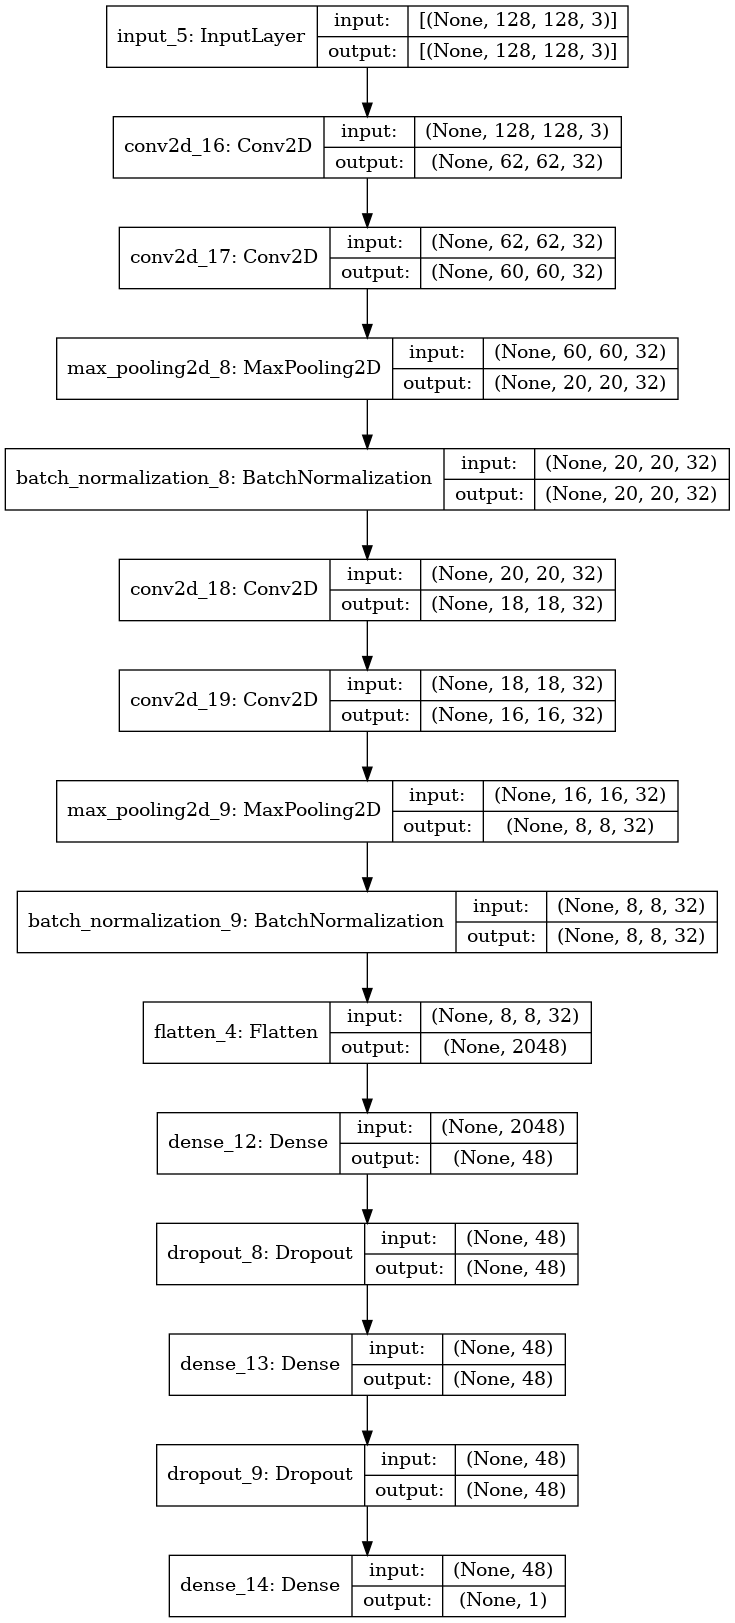

In [83]:
def modelo():
    model = keras.Sequential(
    [
        layers.InputLayer(input_shape),
        layers.Conv2D(filters=32,kernel_size=5,strides=2, activation="relu"),
        layers.Conv2D(32, 3, activation="relu"),
        layers.MaxPooling2D(pool_size=3),
        layers.BatchNormalization(),
        
        layers.Conv2D(32,3, activation="relu"),
        layers.Conv2D(32,3, activation="relu"),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(48,activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(48,activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid"),
    ]
)

    return model

model = modelo()

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#model.summary()
keras.utils.plot_model(model, "arquitetura.png", show_shapes=True)

## Testando os Labels carregadas da base de treinamento.

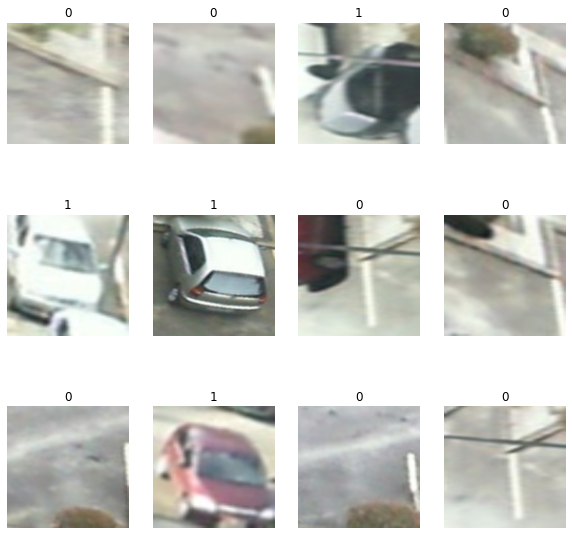

In [84]:
plt.figure(figsize=(10, 10))
for images, labels in X.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Exemplo de Imagem não segmentada.

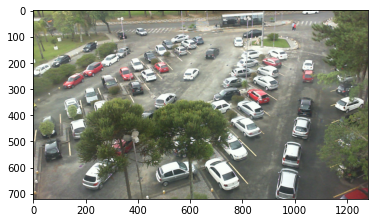

In [85]:
img_full = os.path.join(BASE_PATH[0],BASE_PATH[1],
                        'dataset2','PKLot','UFPR04','Sunny','2012-12-07','2012-12-07_17_12_25.jpg')

img_full = plt.imread(img_full)
plt.imshow(img_full)

## Treinando o modelo.

In [86]:
%%time

if flag:
    model.fit(X, epochs=5)
else:
    LOAD_DIR = os.path.split(DATASET_DIR)[0] # Separa (head,tail) -> Indice [0] = head
    LOAD_DIR = os.path.join(LOAD_DIR,'model')

    model = keras.models.load_model(LOAD_DIR)
    

Epoch 1/5
2316/2316 [==============================] - 332s 143ms/step - loss: 0.0406 - accuracy: 0.9859
Epoch 2/5
2316/2316 [==============================] - 332s 143ms/step - loss: 0.0095 - accuracy: 0.9976
Epoch 3/5
2316/2316 [==============================] - 331s 143ms/step - loss: 0.0053 - accuracy: 0.9987
Epoch 4/5
2316/2316 [==============================] - 333s 144ms/step - loss: 0.0037 - accuracy: 0.9991
Epoch 5/5
2316/2316 [==============================] - 330s 143ms/step - loss: 0.0037 - accuracy: 0.9990
CPU times: user 2h 19min 46s, sys: 2min 51s, total: 2h 22min 38s
Wall time: 27min 38s


## Validação do modelo treinado. (testando na base de dados de validação)

In [87]:
score = model.evaluate(X_val, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

993/993 - 44s - loss: 0.0166 - accuracy: 0.9959
Test loss: 0.016579898074269295
Test accuracy: 0.995874285697937


## Salvando o modelo treinado.

In [88]:
if flag:
    SAVE_DIR = os.path.split(DATASET_DIR)[0] # Separa (head,tail) -> Indice [0] = head
    SAVE_DIR = os.path.join(SAVE_DIR,'model')
    model.save(
        SAVE_DIR,
        overwrite=False,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None,
        save_traces=True,
    )

[WARNING] ../../datasets/dataset2/PKLotSegmented/UFPR04/model already exists - overwrite? [y/n] y


[TIP] Next time specify overwrite=True!


2021-08-29 16:20:02.169375: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../datasets/dataset2/PKLotSegmented/UFPR04/model/assets


## Validação individual (random) na base de treinamento

Vaga livre: 100.00 porcento.
Vaga ocupada 0.00 porcento.


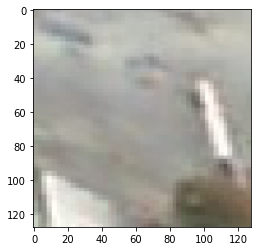

In [100]:
path = X.file_paths[np.random.randint(len(X.file_paths))]
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
score = predictions[0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

#plot = plt.imread(path)
#plt.imshow(img,cmap='gray')
plt.imshow(img)

## Validação individual (random) no Banco de testes

Vaga livre: 100.00 porcento.
Vaga ocupada 0.00 porcento.


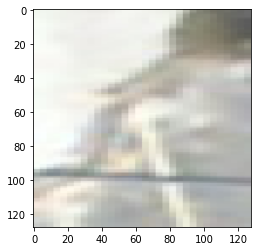

In [105]:
path = X_val.file_paths[np.random.randint(len(X_val.file_paths))]
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
score = predictions[0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

#plot = plt.imread(path)
plt.imshow(img)


## Debug 

ImagemCompleta = os.path.join(IMAGE_DIR,'2012-12-07_19_02_27.jpg')
im = cv2.imread(ImagemCompleta)

if im is None:
    sys.exit("A imagem não foi carregada.")


    
    




r = cv2.selectROI(im)
imCrop = im[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]

imCrop = im[389:508,995:1058] #(y1:y2,x1:x2)
#imCrop = cv2.resize(imCrop, (70,50), interpolation = cv2.INTER_AREA)

imCrop = im[190:260,995:1058] #(y1:y2,x1:x2)
imCrop = cv2.resize(imCrop, (70,50), interpolation = cv2.INTER_AREA)

#cv2.line(im,(720,549),(805,665),(255,0,0),5)
#cv2.line(im,(715,698),(644,582),(255,0,0),5)
#cv2.rectangle(im,(644,582),(805,665),(0,255,0),3)

pts = np.array([[0,0],[0,0],[0,0],[0,0]], np.int32)
pts[0:4] = [720,549],[805,665],[715,698],[644,582]

pts2 = np.array([[0,0],[0,0],[0,0],[0,0]], np.int32)
pts2[0:4] = [769,451],[849,534],[789,586],[701,489]
#pts = pts.reshape((-1,1,2))
#blank = np.zeros(im.shape[:2])
cv2.polylines(im,[pts],True,(0,255,255),5)
cv2.polylines(im,[pts2],True,(0,255,255),5)

<point x="769" y="451"/>
<point x="849" y="534"/>
<point x="789" y="586"/>
<point x="701" y="489"/>

cv2.imshow("Estacionamento", im)
k = cv2.waitKey(0)

if k == ord('q'):
    cv2.destroyAllWindows()

#img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(im)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
#score = predictions[0][0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

#plot = plt.imread(imCrop)
#plt.imshow(plot)

predictions


img_array = keras.preprocessing.image.img_to_array(imCrop)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
predictions

predictions[0][0]

score

pts[0:2]

pts

In [151]:
path2 = '/dataset2/PKLot/UFPR04/Sunny/2012-12-07'
path2 = os.path.normpath(path2)
path2 = path2.split(os.sep)

IMAGE_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],path2[1],path2[2],path2[3],path2[4],path2[5])

#!ls $IMAGE_DIR



In [152]:
ImagemCompleta = os.path.join(IMAGE_DIR,'2012-12-07_19_02_27.jpg')
im = cv2.imread(ImagemCompleta)

if im is None:
    sys.exit("A imagem não foi carregada.")


In [153]:
import xml.etree.ElementTree as ET

tree = ET.parse('/home/pedrodsk/datasets/dataset2/PKLot/UFPR04/Sunny/2012-12-07/2012-12-07_19_02_27.xml')
root = tree.getroot()

pts = np.empty(0,np.int32)

for neighbor in root.iter('point'):
    #print(neighbor.attrib)
    x,y = neighbor.attrib.values()
    x = int(x)
    y = int(y)
    a = [x,y]
    pts = np.append(pts,[x,y])


In [154]:
a = np.array(np.zeros((112,2)),np.int32)
j=0
for i in range(112):
    a[i] = pts[j:j+2]
    j = j+2

In [144]:
#a = np.array(np.zeros((4,2)),np.int32)
#a[0] = pts[0:2]
#a[1] = pts[2:4]
#a[2] = pts[4:6]
#a[4] = pts[6:8]

#pts = a[0:4]
#pts = pts.reshape((-1, 1, 2))
#roi = np.ones(im.shape, dtype='uint8')

#roi = im[549:698,644:720]
pts2 = np.array(np.zeros((112,2)),np.int32)
#pts = np.array([[0,0],[0,0],[0,0],[0,0]], np.int32)

pts2[0:4] = a[0:4]
pts2[4:8] = a[4:8]
#pts = pts.reshape((-1, 1, 2))

cv2.polylines(im,[pts2[0:4],pts2[4:8]],True,(0,255,255),3)
#cv2.rectangle(roi,(30,30),(370,370),255,1)
#bitwise_and = cv2.bitwise_and(vaga1,im)


array([[[ 64,  90,  77],
        [ 51,  83,  72],
        [ 85, 125, 114],
        ...,
        [ 77, 123, 111],
        [ 84, 132, 120],
        [ 85, 136, 122]],

       [[ 65,  89,  77],
        [ 51,  78,  68],
        [ 70, 107,  97],
        ...,
        [ 85, 130, 121],
        [ 88, 138, 126],
        [ 91, 141, 129]],

       [[ 79,  99,  87],
        [ 58,  82,  72],
        [ 55,  89,  79],
        ...,
        [ 86, 132, 126],
        [ 88, 137, 129],
        [ 87, 138, 130]],

       ...,

       [[114, 114, 120],
        [115, 116, 120],
        [112, 110, 116],
        ...,
        [ 49,  45,  87],
        [ 50,  46,  87],
        [ 51,  48,  87]],

       [[109, 111, 119],
        [111, 114, 119],
        [109, 108, 117],
        ...,
        [ 46,  38,  85],
        [ 46,  39,  82],
        [ 47,  41,  82]],

       [[109, 111, 119],
        [111, 113, 121],
        [109, 108, 117],
        ...,
        [ 43,  34,  84],
        [ 44,  37,  82],
        [ 44,  37,  80]]

In [137]:
a[0:4]

array([[720, 549],
       [805, 665],
       [715, 698],
       [644, 582]], dtype=int32)

In [155]:
a = np.array(np.zeros((112,2)),np.int32)
j=0
for i in range(112):
    a[i] = pts[j:j+2]
    j = j+2

j=0
for k in range(28):
    #print(j)
    pts2[j:j+4] = a[j:j+4]
    cv2.polylines(im,[pts2[j:j+4]],True,(0,255,255),3)
    j=j+4
    

cv2.polylines(im,[pts2[4:8]],True,(0,255,0),3)


array([[[ 64,  90,  77],
        [ 51,  83,  72],
        [ 85, 125, 114],
        ...,
        [ 77, 123, 111],
        [ 84, 132, 120],
        [ 85, 136, 122]],

       [[ 65,  89,  77],
        [ 51,  78,  68],
        [ 70, 107,  97],
        ...,
        [ 85, 130, 121],
        [ 88, 138, 126],
        [ 91, 141, 129]],

       [[ 79,  99,  87],
        [ 58,  82,  72],
        [ 55,  89,  79],
        ...,
        [ 86, 132, 126],
        [ 88, 137, 129],
        [ 87, 138, 130]],

       ...,

       [[114, 114, 120],
        [115, 116, 120],
        [112, 110, 116],
        ...,
        [ 49,  45,  87],
        [ 50,  46,  87],
        [ 51,  48,  87]],

       [[109, 111, 119],
        [111, 114, 119],
        [109, 108, 117],
        ...,
        [ 46,  38,  85],
        [ 46,  39,  82],
        [ 47,  41,  82]],

       [[109, 111, 119],
        [111, 113, 121],
        [109, 108, 117],
        ...,
        [ 43,  34,  84],
        [ 44,  37,  82],
        [ 44,  37,  80]]

In [156]:
cv2.imshow("Estacionamento", im)

k = cv2.waitKey(0)

if k == ord('q'):
    cv2.destroyAllWindows()

In [264]:
cv2.imshow("Estacionamento", roi)
k = cv2.waitKey(0)

if k == ord('q'):
    cv2.destroyAllWindows()

In [91]:
a[0:4]

array([[720, 549],
       [805, 665],
       [715, 698],
       [644, 582]], dtype=int32)

In [89]:
pts

array([[528,  98],
       [554, 129],
       [525, 148],
       [491, 110]], dtype=int32)

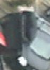

In [276]:
img

In [277]:
img_array

<tf.Tensor: shape=(1, 70, 50, 3), dtype=float32, numpy=
array([[[[171., 158., 139.],
         [160., 149., 131.],
         [146., 135., 117.],
         ...,
         [191., 194., 173.],
         [188., 190., 166.],
         [178., 178., 152.]],

        [[169., 158., 138.],
         [159., 151., 130.],
         [148., 140., 121.],
         ...,
         [175., 177., 156.],
         [191., 190., 169.],
         [199., 197., 174.]],

        [[164., 156., 135.],
         [156., 150., 128.],
         [149., 142., 123.],
         ...,
         [165., 164., 146.],
         [181., 178., 159.],
         [202., 200., 179.]],

        ...,

        [[ 79.,  86.,  92.],
         [ 64.,  69.,  73.],
         [ 76.,  80.,  83.],
         ...,
         [153., 161., 164.],
         [146., 151., 154.],
         [149., 153., 154.]],

        [[ 84.,  89.,  95.],
         [ 66.,  71.,  75.],
         [ 70.,  74.,  77.],
         ...,
         [141., 149., 151.],
         [137., 143., 143.],
         [1

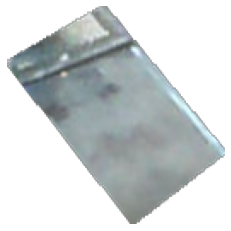

In [55]:
import os

BASE_PATH = ['../..','datasets']
path2 = '/dataset2/PKLot/UFPR04/Sunny/2012-12-07'
path2 = os.path.normpath(path2)
path2 = path2.split(os.sep)

IMAGE_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],path2[1],path2[2],path2[3],path2[4],path2[5])

ImagemCompleta = os.path.join(IMAGE_DIR,'2012-12-07_19_02_27.jpg')

#im = cv2.imread("exemplo.png")
im = cv2.imread(ImagemCompleta)

if im is None:
    sys.exit("A imagem não foi carregada.")

#pts = np.array([[10,150],[150,100],[300,150],[350,100],[310,20],[35,10]])
i=2
pts2 = pts[16:18],pts[18:20],pts[20:22],pts[22:24]
pts2 = np.array(pts2)

rect = cv2.boundingRect(pts2)
x,y,w,h = rect
croped = im[y:y+h, x:x+w].copy()

pts2 = pts2 - pts2.min(axis=0)
mask = np.zeros(croped.shape[:2], croped.dtype)
cv2.drawContours(mask, [pts2], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)

tmp = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
_,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
b, g, r = cv2.split(dst)
rgba = [b,g,r, alpha]
masked_tr = cv2.merge(rgba,4)

#masked_tr = cv2.cvtColor(masked_tr, cv2.COLOR_BGR2GRAY)
image = cv2.resize(masked_tr, (128,128), interpolation = cv2.INTER_CUBIC)

cv2.imwrite('vaga1.png', image)
plt.axis('off')
plt.imshow(image)



Vaga livre: 0.00 porcento.
Vaga ocupada 100.00 porcento.


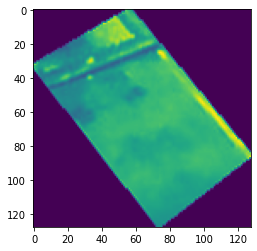

In [62]:
path = '/home/pedrodsk/cursos/tcc/vaga1.png'
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2],grayscale=True)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
score = predictions[0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

#plot = plt.imread(path)
plt.imshow(img)




In [155]:
image = np.reshape[128,128,3]

TypeError: list indices must be integers or slices, not tuple

In [41]:
path = X.file_paths[np.random.randint(len(X.file_paths))]
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(img)
img_array.shape

(128, 128, 3)

In [42]:
img_array = tf.expand_dims(img_array,  0)
img_array

<tf.Tensor: shape=(1, 128, 128, 3), dtype=float32, numpy=
array([[[[101.,  87.,  74.],
         [101.,  87.,  74.],
         [ 97.,  85.,  69.],
         ...,
         [ 85.,  83.,  70.],
         [ 83.,  81.,  68.],
         [ 83.,  81.,  68.]],

        [[ 99.,  85.,  72.],
         [ 99.,  85.,  72.],
         [ 94.,  82.,  68.],
         ...,
         [ 83.,  81.,  68.],
         [ 88.,  86.,  73.],
         [ 88.,  86.,  73.]],

        [[ 95.,  81.,  68.],
         [ 95.,  81.,  68.],
         [ 90.,  76.,  63.],
         ...,
         [ 80.,  81.,  67.],
         [ 96.,  97.,  83.],
         [ 96.,  97.,  83.]],

        ...,

        [[120., 121., 113.],
         [120., 121., 113.],
         [121., 122., 114.],
         ...,
         [114., 116., 111.],
         [114., 116., 111.],
         [114., 116., 111.]],

        [[119., 120., 114.],
         [119., 120., 114.],
         [119., 120., 114.],
         ...,
         [116., 119., 112.],
         [118., 119., 113.],
         

In [43]:
img_array = tf.expand_dims(img_array,  0)

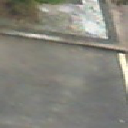

In [44]:
img